# SME0828 - Introdução a Ciência de Dados

Juan Lucas Montanaro

## Sumário

*   Introdução
*   Análise Exploratória
*   Modelos
    *   Núcleo Polinomial
    *   Núcleo Radial
*   Escolha do melhor Modelo
*   Resultados e Conclusões



## Introdução

Para o meu projeto, resolvi trabalhar em uma das competições da plataforma _kaggle_, o reconhecimento de dígitos (disponível neste [link](https://www.kaggle.com/c/digit-recognizer)), ou seja, o objetivo é ajustar um algoritmo que consiga reconhecer e classificar os digítos do conjunto de imagens fornecidos. Para isto, a plataforma fornece, além do conjunto de teste, um conjunto de treino, o clássico [MNIST](http://yann.lecun.com/exdb/mnist/index.html), com 42.000 imagens vetorizadas de dígitos "escritos" à mão, sendo todas com resolução de 28 por 28 pixels; veja o conjunto a seguir.

In [ ]:
# importação dos dados
import pandas as pd
import numpy as np

np.random.seed(2021)

data = pd.read_csv('train.csv', header=(0))
nlin, ncol = data.shape
print('Tamanho dos dados:', nlin, 'linhas por', ncol, 'colunas.')
data.head(5)

Tamanho dos dados: 42000 linhas por 785 colunas.


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Perceba, a primeira coluna é a indicação de qual é o dígito nesta forma de vetor, enquanto que as outras colunas são os valores de cada pixel (na escala de cinza, ou seja, zero indica que o pixel é preto e 255, que é branco), mas apenas pela tabela nem pode-se dizer que este é um conjunto de imagens, então, vejamos os primeiros vetores reajustados na forma de gráfico.

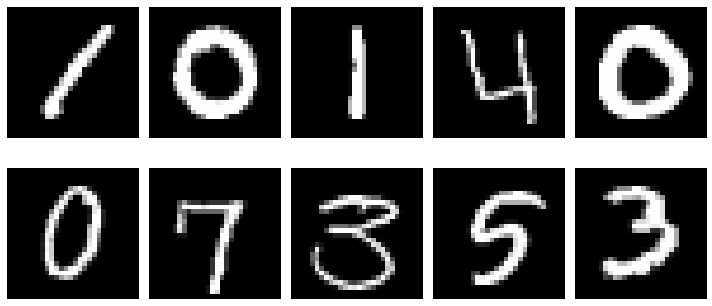

In [ ]:
# Grafico dos primeiros digitos:
import matplotlib.pyplot as plt

vetores = data.drop('label', 1).values
v_graf = vetores.reshape(-1,28,28)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
axs = np.ravel(axs)

for i in range(len(axs)):
    plt.sca(axs[i])
    plt.imshow(v_graf[i], cmap='gray')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

Dessa forma, vemos que de fato os vetores representam imagens, e além disso, os digítos estão centralizados no meio, então possívelmente será possível retirar algumas colunas do conjunto de dados, para economizar tempo de processamento. Na verdade, para aplicar qualquer mudança no dados são necessários os resultados de uma análise exploratória, pelo menos, então vamos a isto.

## Análise Exploratória

Então, nesta seção será feita a análise exploratória do conjunto de dados, fundamental para entender os dados e considerar as melhores transformações e técnicas de limpeza. Logo, começemos verificando a existência de imagens repetidas no conjunto.

In [ ]:
# Verificando duplicatas
aux = data.duplicated()
dup = []
for i in range(0, 42000):
  if (aux[i]): dup.append(i)
print('Quantidade de imagens idênticas:', len(dup))

Quantidade de imagens idênticas: 0


Vemos que não há imagens repetidas. Continuando, vejamos como estão distribuídas as quantidades de cada digíto, vejamos o histograma dos digítos.

In [ ]:
# Definindo as variaveis independente e dependente:
X = vetores
y = data.label.values

# deletando variaveis que nao serao usadas
del vetores
del dup

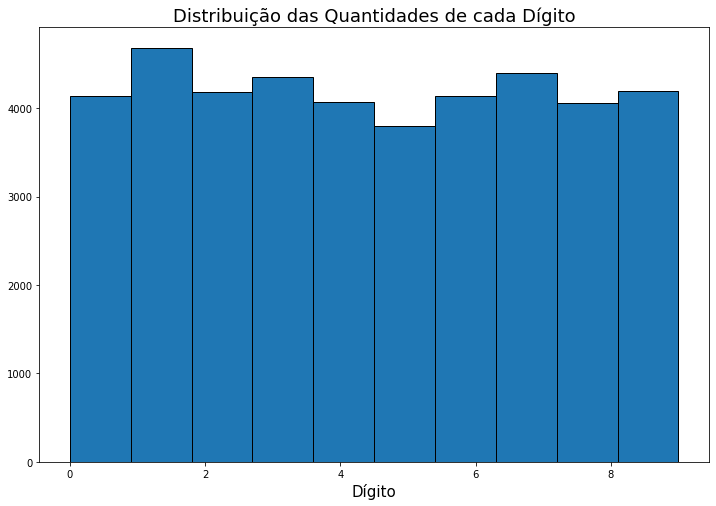

In [ ]:
# histograma dos valores de Y
plt.figure(figsize=(12, 8))
plt.hist(y, edgecolor='black')
plt.title('Distribuição das Quantidades de cada Dígito', fontsize=18)
plt.xlabel('Dígito', fontsize=15)
plt.show()

Portanto, temos que a distribuição dos digítos é praticamente uniforme, logo, provavelmente não existirá uma tendência do algoritmo por classificar mais frequentemente algum digíto.

Agora, vamos considerar a distribuição de valores por pixel, isto é, quais valores aparecem em cada pixel.

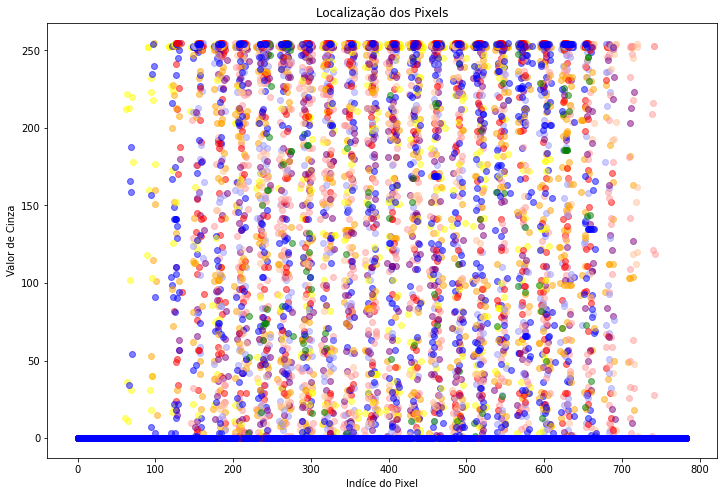

In [ ]:
# Dispersao de algumas linhas de X
plt.figure(figsize=(12,8))
cor = {0: 'black', 1: 'red', 2: 'blue', 3: 'orange', 4: 'purple',
       5: 'green', 6: 'yellow', 7: '#ff9999', 8: '#9999ff', 9: '#ffc299'}
for i in range(0, 42000, 1000):
  plt.scatter(np.array(range(0,784)), X[i,:],
              color=cor[y[i]], alpha=0.5)
plt.title('Localização dos Pixels')
plt.xlabel('Indíce do Pixel')
plt.ylabel('Valor de Cinza')
plt.show()

Mesmo considerando apenas 0,1% dos dados, é possível perceber que a distribuição de valores entre os pixels é aleatória, nem mesmo uma tedência por dígito (na caso, separação por cor) existe. Ainda assim, vemos que aproximadamente os primeiros e últimos 50 pixels valem zero, logo, poderão ser retirados.

A seguir, veja o resumo por coluna.

In [ ]:
aux = data.describe()
print(aux)

              label   pixel0   pixel1  ...  pixel781  pixel782  pixel783
count  42000.000000  42000.0  42000.0  ...   42000.0   42000.0   42000.0
mean       4.456643      0.0      0.0  ...       0.0       0.0       0.0
std        2.887730      0.0      0.0  ...       0.0       0.0       0.0
min        0.000000      0.0      0.0  ...       0.0       0.0       0.0
25%        2.000000      0.0      0.0  ...       0.0       0.0       0.0
50%        4.000000      0.0      0.0  ...       0.0       0.0       0.0
75%        7.000000      0.0      0.0  ...       0.0       0.0       0.0
max        9.000000      0.0      0.0  ...       0.0       0.0       0.0

[8 rows x 785 columns]


Podemos usar esta tabela para descobrir quais colunas possuem apenas valores zeros, isto é, quais colunas tem o _"máximo"_ igual zero.

In [ ]:
# Colunas com apenas zeros
ind_zero = [] #lista com os indices
aux = aux.iloc[7, 0:aux.shape[1]] #selecionando a linha do "maximo"

for j in range(0, len(aux)):
  if (aux[j] == 0): ind_zero.append(j)
print('Quantidade de colunas com apenas zeros:', len(ind_zero))

Quantidade de colunas com apenas zeros: 76


Como esperado, temos um número significativo de colunas apenas com zeros, assim, vejamos como seria o resumo sem elas.

In [ ]:
data_2 = data.drop(data.columns[ind_zero], axis=1)
aux = data_2.describe()
print(aux)

              label      pixel12  ...      pixel778      pixel779
count  42000.000000  42000.00000  ...  42000.000000  42000.000000
mean       4.456643      0.00300  ...      0.017238      0.002857
std        2.887730      0.56812  ...      1.894498      0.414264
min        0.000000      0.00000  ...      0.000000      0.000000
25%        2.000000      0.00000  ...      0.000000      0.000000
50%        4.000000      0.00000  ...      0.000000      0.000000
75%        7.000000      0.00000  ...      0.000000      0.000000
max        9.000000    116.00000  ...    254.000000     62.000000

[8 rows x 709 columns]


Claramente, ele está diferente, as imagens deste novo conjunto não apresentam mais bordas vazias, agora todos os pixels possuem relevância. Mas não sabemos o quão relevantes eles são, desta forma, para descobrir isto, vamos considerar a análise pela matriz de correlações.

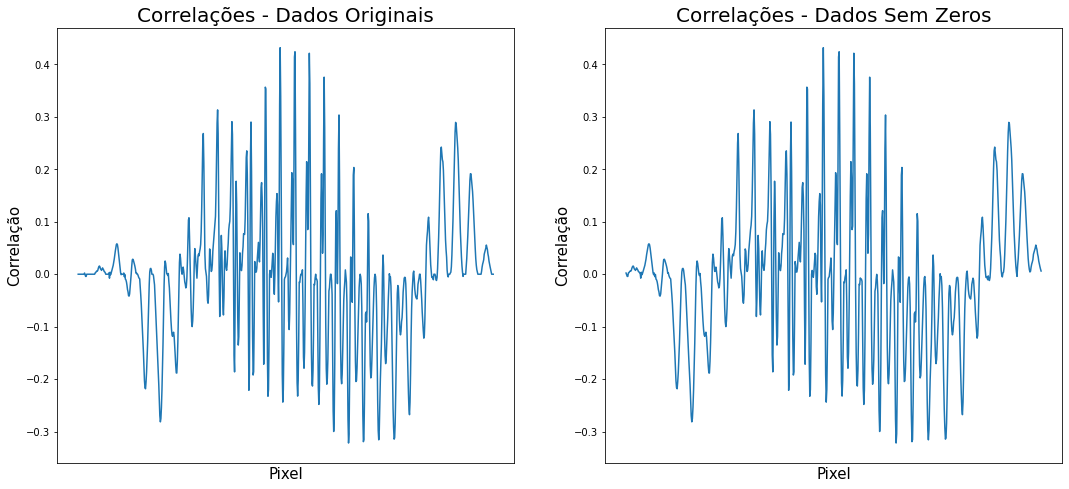

In [ ]:
# tabela de correlacoes
corr_1 = data.corr()
corr_2 = data_2.corr()

# apenas as correlacoes entre 'label' e os pixels
aux_1 = corr_1.iloc[0:corr_1.shape[0], 0]
aux_1 = aux_1.drop(aux_1.index[0], axis=0)
aux_1 = aux_1.replace(np.nan, 0) 

aux_2 = corr_2.iloc[0:corr_2.shape[0], 0]
aux_2 = aux_2.drop(aux_2.index[0], axis=0)
aux_2 = aux_2.replace(np.nan, 0)

# grafico destas correlacoes
fig, ax = plt.subplots(1,2, figsize=(18,8))

ax[0].plot(aux_1)
ax[0].set_title('Correlações - Dados Originais', fontsize=20)
ax[0].set_xticks([])
ax[0].set_xlabel('Pixel', fontsize=15)
ax[0].set_ylabel('Correlação', fontsize=15)

ax[1].plot(aux_2)
ax[1].set_title('Correlações - Dados Sem Zeros', fontsize=20)
ax[1].set_xticks([])
ax[1].set_xlabel('Pixel', fontsize=15)
ax[1].set_ylabel('Correlação', fontsize=15)

fig.show
plt.show()

Nestes gráficos vemos as correlações entre cada pixel e a indicação de qual é o digíto tanto para o conjunto original quanto para o conjunto sem as colunas com exclusivamente zeros, e de fato, as colunas com zeros são irrelevantes, pois as correlações não mudam.

Na verdade, analisando as duas matrizes (o que não será mostrado por causa do tamanho delas) é possível perceber que elas são praticamente iguais, diferindo nas linhas e colunas que estão a mais na primeira matriz.

Além disso, vemos pelos gráficos e pelas matrizes que existem várias correlações próximas de zero, dessa forma, poderemos diminuir as dimensões do problema usando a análise de componentes principais (_"PCA"_, em inglês), tal que eles expliquem alguma quantidade significativa da variância presente nos dados.

Porém, antes de seguir adiante com os códigos aplicando o PCA, vou considerar uma mudança nos valores dos pixels: testando algumas vezes, conclui que a melhor escala são para os valores de zero a cinco, então, irei aplicar esta transformação.

In [ ]:
#Tratamento dos dados:
from sklearn.preprocessing import MinMaxScaler

X_2 = data_2.drop('label', 1).values
# vou manter estes valores para comparações

min_max = MinMaxScaler(feature_range=(0,5))
X = min_max.fit_transform(X)
X_2 = min_max.fit_transform(X_2)

print('Tratamento concluido.')

Tratamento concluido.


Aplicada a nova escala nos dados, vamos trabalhar com o PCA agora. E, também analisando antes, descobri que se forem usados 154 componentes, então eles explicarão 95% da variância dos dados, o que acredito ser o suficiente. Assim, irei redimensionalisar os dados para apenas 154 colunas, considerando os autovetores principais.

In [ ]:
# redimensionalizacao
from sklearn.decomposition import PCA

pca = PCA(154, random_state=41).fit(X)
pca_2 = PCA(154, random_state=41).fit(X_2)

Para visulizar a relação entre a quantidade de componentes e a quantidade de variância explicada, considere o gráfico a baixo.

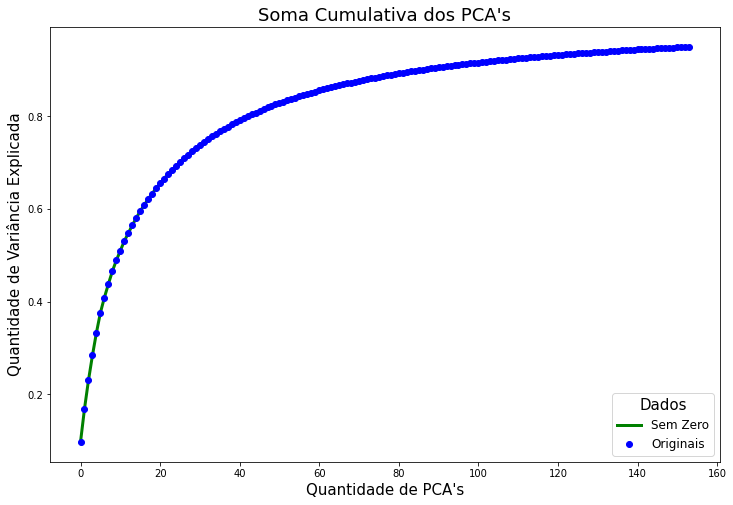

In [ ]:
# Screen plot com a soma cumulativa
plt.figure(figsize=(12,8))
plt.plot(pca_2.explained_variance_ratio_.cumsum(),'g-',label='Sem Zero',lw=3)
plt.plot(pca.explained_variance_ratio_.cumsum(), 'bo', label='Originais')
plt.title("Soma Cumulativa dos PCA's", fontsize=18)
plt.xlabel("Quantidade de PCA's", fontsize=15)
plt.ylabel("Quantidade de Variância Explicada", fontsize=15)
plt.legend(title='Dados', loc='lower right', fontsize=12, title_fontsize=15)
plt.show()

Em primeiro lugar, vemos que retirar ou não retirar as colunas com apenas zeros não faz diferença na análise dos componentes principais, o que já era esperado. 

Em segundo lugar, conforme aumentamos a quantidade de compoentes, menos significância ele possui e pouco a mais da variância é explicado, ou seja, poderia ser considerada uma quantidade de variância um pouco menor a ser explicada e muito menos componentes a serem usado, o que acelararia o processo de análise e escolha do modelo.

Mas, ainda considero que 95% da variância e 154 componentes é a escolha correta, e continuarei o relatório com estes dados. Logo, considere a transformação dos dados pelo PCA a seguir.

In [ ]:
# Ajuste no conjuntos de dados, segundo o PCA
X_pca = pca.transform(X)

# Separacao dos conjuntos de treino e teste
from sklearn.model_selection import train_test_split

X1, x2, Y1, y2 = train_test_split(X_pca, y, train_size=0.15,
                                  stratify=y, random_state=41)

Para terminar o tópico de análise exploratória, todas as transformações que acredito serem necessárias foram feitas e os conjuntos de treino e validação já foram separados também. Agora, vamos a tópico de escolha do modelo.

## Modelos

Já foram feitas as transformações, temos os conjuntos de treino e validação, o próximo passo agora é realizar o estudo sobre os melhores modelos, escolher os melhores parâmetros e eventualmente testar o modelo escolhido no conjunto de teste.

Mas, antes de seguir com estes passos, quero explicar que, baseado no que foi visto em aula e na estrutura do problema, eu havia escolhido a classe de modelos "K-vizinhos mais próximos" (_"KNN"_, em inglês), porém o tempo de processamento para ajustar um único modelo estava muito grande, dessa forma, não daria para estudar e escolher os parâmetros.

Então, decidi trocar para os modelos "support vector machines" (_"SVM"_), os quais se mostraram bem mais rápidos, e considerando apenas os modelos com núcleos polinomiais e radiais, foram muito eficientes também.

Portanto, neste tópico, estará o meu estudo e escolha dos melhores parâmetros para os modelos _SVM_, limitados aos núcleos polinomias e radiais.

### Núcleo Polinomial

Começando com os núcleos polinomiais, preciso dizer que testei várias combinações de parâmetros, para que pudesse exibir no relatório apenas os melhores.

Ademais, antes, estava testando usando `for` para verificar a eficácia dos parâmetros (loops encaixados e validação cruzada, um modelo por vez). Mas pesquisando melhor, descobri a função `GridSearchCV`, que realiza o mesmo processo de forma mais rápida, além de ajudar na organização do código.

Dessa forma, a seguir, estão os códigos em que seleciono os melhores parâmetros para o modelo SVM com núcleo polinomial.

In [ ]:
# Selecao de modelo:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model = SVC(kernel='poly', cache_size=1000)

# realiza a validação cruzada
parametros = {'C'     : [0.2, 1, 5, 50, 100],
              'degree': [2, 3, 4],
              'gamma' : [0.0002,0.0004,0.0006,0.0008]
              }
nkf = 5 #numero de subconjuntos
grid = GridSearchCV(estimator = model,
                    param_grid = parametros,
                    cv = nkf)

# Testando os parametros
grid.fit(X1, Y1)

print('Modelos polinomiais treinados.')

Modelos polinomiais treinados.


Testadas todas as combinações possíveis, vejamos a taxa média de acerto dos dez primeiros melhores modelos.

In [ ]:
# Salva os resultados
results_poli = pd.DataFrame(grid.cv_results_)

# Imprime algumas colunas de interesse
#results_poli[['params','rank_test_score','mean_test_score','std_test_score']]

# 10 primeiros melhores resultados
results_poli.sort_values(by='rank_test_score').iloc[0:10, [7, 13, 14, 15]]

,params,mean_test_score,std_test_score,rank_test_score
43,"{'C': 50, 'degree': 3, 'gamma': 0.0008}",0.961905,0.004518,1
55,"{'C': 100, 'degree': 3, 'gamma': 0.0008}",0.961905,0.004518,1
54,"{'C': 100, 'degree': 3, 'gamma': 0.0006}",0.961905,0.004518,1
53,"{'C': 100, 'degree': 3, 'gamma': 0.0004}",0.961905,0.004518,1
42,"{'C': 50, 'degree': 3, 'gamma': 0.0006}",0.961905,0.004518,1
41,"{'C': 50, 'degree': 3, 'gamma': 0.0004}",0.961429,0.004562,6
31,"{'C': 5, 'degree': 3, 'gamma': 0.0008}",0.961270,0.004501,7
30,"{'C': 5, 'degree': 3, 'gamma': 0.0006}",0.960794,0.004959,8
52,"{'C': 100, 'degree': 3, 'gamma': 0.0002}",0.960635,0.005231,9
50,"{'C': 100, 'degree': 2, 'gamma': 0.0006}",0.958095,0.006053,10


Vemos que os cinco primeiros itens possuem a mesma acurária média, e na verdade isso aconteceu repetidas vezes, não sei exatamente o porquê, mas, apenas utilizando a tabela, poderíasse dizer que os parâmetros `gamma` e `C` não são relevantes quando o grau do polinômio ajustado é três.

Mas continuando, veja um gráfico da acurácia média versus as combinações de parâmetros.

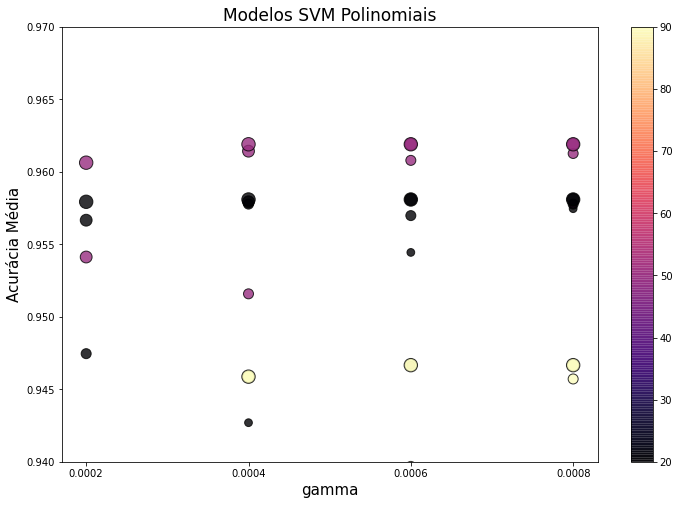

In [ ]:
# Grafico comparativo:
plt.figure(figsize=(12,8))

tam = results_poli['param_C']
tam = tam.replace([0.2, 1, 5, 50, 100],
                  [20, 60, 100, 140, 180])

cores = results_poli['param_degree']
cores = cores.replace([2,3,4], [20, 50, 90])

plt.scatter(np.array(results_poli['param_gamma'], dtype='str'),
           np.array(results_poli['mean_test_score']), s=tam,
           c=cores, cmap='magma', alpha=0.8, edgecolors='black')

plt.title('Modelos SVM Polinomiais', fontsize=17)
plt.xlabel('gamma', fontsize = 15)
plt.ylabel('Acurácia Média', fontsize = 15)
plt.ylim([0.94, 0.97])
plt.colorbar()
plt.show(True)

O gráfico apenas confirma as observações anteriores feitas apenas com a tabela. Entretanto, ainda é preciso escolher um modelo, portanto, decidi apenas escolher o primeiro item da tabela.

E, a seguir, irei inverter os conjuntos de treino e validação para treinar o modelo polinomial com os melhores parâmetros, para simular qual será a real taxa de acertos considerando todas as observações de treino para a predição das observações de teste.

In [ ]:
# Melhor modelo Polinomial
from sklearn.metrics import accuracy_score

mod_p = SVC(kernel='poly', C=50, degree=3,
            gamma=0.0008, cache_size=1000)
mod_p.fit(x2, y2)

y_pred_p = mod_p.predict(X1)
acur_p = accuracy_score(Y1, y_pred_p)
print('Acurácia média:', acur_p)

Acurácia média: 0.9817460317460317


Temos que este é um modelo muito bom, com uma taxa de acertos bem alta. Vejamos com está a matriz de confunsão.

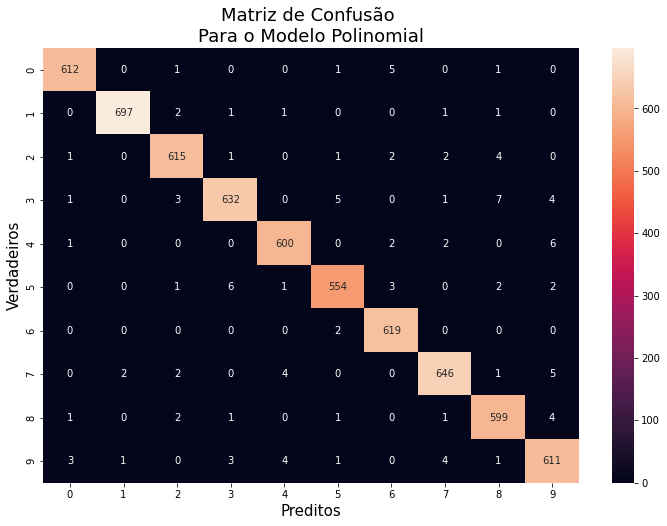

In [ ]:
# Tabela de confusao
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm_p = confusion_matrix(Y1, y_pred_p)
plt.subplots(figsize=(12, 8))
sb.heatmap(cm_p, annot = True, fmt = 'g')
plt.xlabel("Preditos", fontsize=15)
plt.ylabel("Verdadeiros", fontsize=15)
plt.title("Matriz de Confusão \nPara o Modelo Polinomial",
          fontsize=18)
plt.show()

Infelizmente, vários digítos estão sendo classificados errados, estando os maiores erros nos pares: 0-6, 3-5, 3-8, 4-7, 4-9 e 7-9. Não vou tentar corrigí-los, ao invés disso, vou ajustar os modelos para o próximo núcleo e repetir a mesma análise.

### Núcleo Radial

Agora, para o núcleo radial, a mesma consideração anterior ainda é válida: vários testes de parâmetros não estão sendo mostrados, apenas os melhores. Dito isso, vejamos os códigos.

In [ ]:
# Ajuste Radial
model_r = SVC(kernel='rbf', cache_size=1000)

# realiza a validação cruzada
parametros_r = {'C'    : [1, 3, 5, 8, 10],
                'gamma': ['scale',0.0010, 0.0012, 0.0014,
                          0.0016, 0.0018, 0.0020]
                }
grid_r = GridSearchCV(estimator = model_r,
                      param_grid = parametros_r,
                      cv = nkf)

# Testando os parametros
grid_r.fit(X1, Y1)

print('Modelos radiais treinados.')

Modelos radiais treinados.


Pelo menos neste caso, há um parâmetro a menos e os testes são bem mais rápidos por isso. Mas vejamos com os parâmetros influênciam a qualidade da predição.

In [ ]:
# Salva os resultados
results_rad = pd.DataFrame(grid_r.cv_results_)

# Imprime algumas colunas de interesse
#results_rad[['params','rank_test_score','mean_test_score','std_test_score']]

# 10 primeiros melhores resultados
results_rad.sort_values(by='rank_test_score').iloc[0:10, [6, 12, 13, 14]]

,params,mean_test_score,std_test_score,rank_test_score
15,"{'C': 5, 'gamma': 0.001}",0.965714,0.004330,1
22,"{'C': 8, 'gamma': 0.001}",0.965397,0.004335,2
29,"{'C': 10, 'gamma': 0.001}",0.965397,0.004335,2
30,"{'C': 10, 'gamma': 0.0012}",0.965238,0.005754,4
23,"{'C': 8, 'gamma': 0.0012}",0.965238,0.005754,4
16,"{'C': 5, 'gamma': 0.0012}",0.965238,0.005754,4
8,"{'C': 3, 'gamma': 0.001}",0.965238,0.004693,4
9,"{'C': 3, 'gamma': 0.0012}",0.965238,0.005797,4
24,"{'C': 8, 'gamma': 0.0014}",0.965079,0.005854,9
21,"{'C': 8, 'gamma': 'scale'}",0.965079,0.005429,9


Temos, então, que o modelos com núcleos radiais aparentam conseguir melhores resultados em comparação aos com núcleos polinomias, a diferencça é pouca, mas ainda existe. Além disso, o parâmetro `C` aparenta ser significativo e determinante na escolha do melhor modelo. Vejamos isto em gráfico.

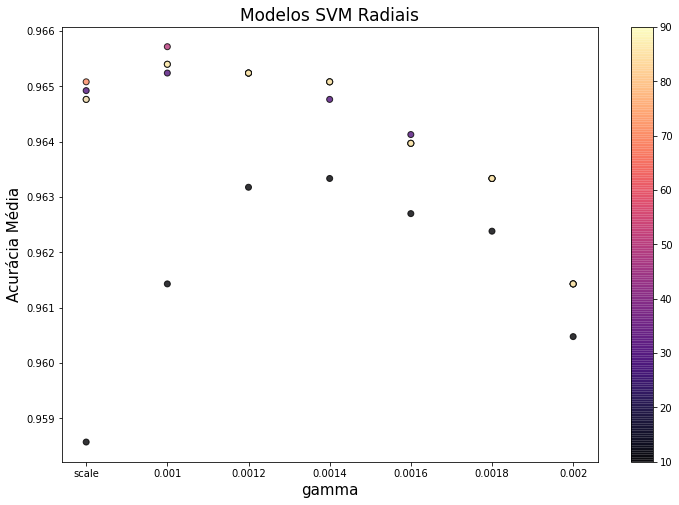

In [ ]:
# Grafico comparativo radial:
plt.figure(figsize=(12,8))

cores = results_rad['param_C']
cores = cores.replace([1, 3, 5, 8, 10],
                      [10, 30, 50, 70, 90])

plt.scatter(np.array(results_rad['param_gamma'], dtype='str'),
         np.array(results_rad['mean_test_score']),
         c=cores, cmap='magma', alpha=0.8, edgecolors='black')

plt.title('Modelos SVM Radiais', fontsize=17)
plt.ylabel('Acurácia Média', fontsize = 15)
plt.xlabel('gamma', fontsize = 15)
plt.colorbar()
plt.show(True)

De fato, o parâmetro `C` é relevante.

Agora, novamente invertendo os conjuntos, vejamos como está o melhor modelo com núcleo radial.

In [ ]:
# Melhor modelo Radial
mod_r = SVC(kernel='rbf', C=5, gamma=0.0010, cache_size=1000)
mod_r.fit(x2, y2)

y_pred_r = mod_r.predict(X1)
acur_r = accuracy_score(Y1, y_pred_r)
print('Acurácia média:', acur_r)

Acurácia média: 0.9831746031746031


Assim como vimos na tabela dos resultados preliminares, aparentemente, o melhor modelo com núcleo radial consegue ser mais preciso do que o melhor modelo com núcleo polinomial. Mas vejamos também como está a matriz de confusão.

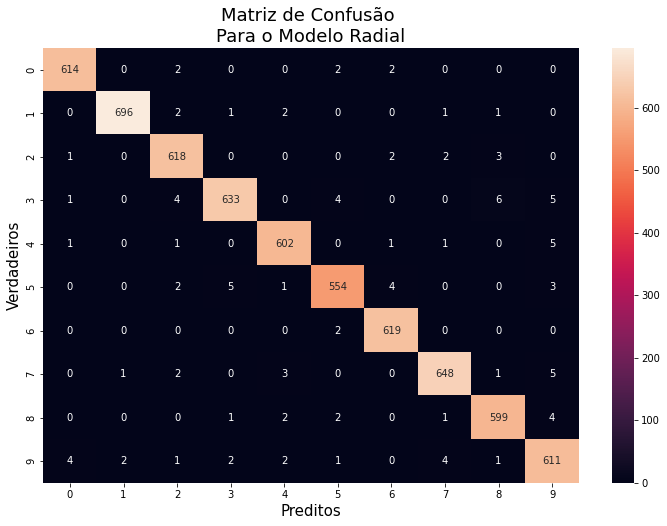

In [ ]:
# Tabela de confusao
cm_r = confusion_matrix(Y1, y_pred_r)
plt.subplots(figsize=(12, 8))
sb.heatmap(cm_r, annot = True, fmt = 'g')
plt.xlabel("Preditos", fontsize=15)
plt.ylabel("Verdadeiros", fontsize=15)
plt.title("Matriz de Confusão \nPara o Modelo Radial",
          fontsize=18)
plt.show()

Dessa vez, o modelo cometeu menos erros e eles também estão mais distribuídos entre todas as classes, sendo os pares mais relevantes: 0-9, 2-3, 3-5, 3-8, 4-7, 4-9, 7-9 e 8-9. Contudo, assim como para o núcleo polinomial, também não tentarei corrigir isto, apenas seguirei com este modelo.

## Escolha do Melhor Modelo

Neste penúltimo tópico, irei ajustar o melhor modelo com todas as observações disponíveis no conjunto de treino, carregar os dados de teste, aplicar neles as mesmas transformações da análise exploratória e realizar a predição do digíto.

Na verdade, optei por considerar o melhor modelo de cada tipo de núcleo, pois, no tópico de seleção de parâmetros, a diferença da acurácia média entre eles foi muito pequena, então será feita uma comparação entre ambos os melhores modelos, sendo esperado que aquele com o núcleo radial seja o mais preciso.

In [ ]:
# Tratamento dos dados de teste
test = pd.read_csv('test.csv', header=(0))
aux = test.to_numpy()
aux = min_max.fit_transform(aux)
teste = pca.transform(aux)
print('Tratamento concluído.',
      '\nNúmero de linhas no conj. de teste:',
      teste.shape[0])

Tratamento concluído. 
Número de linhas no conj. de teste: 28000


In [ ]:
# O melhor modelo de cada nucleo
modelo_p = SVC(kernel='poly', degree=3, C=50,
             gamma=0.0008, cache_size=1000)
modelo_r = SVC(kernel='rbf', C=5, gamma=0.001, cache_size=1000)

modelo_p.fit(X_pca, y)
modelo_r.fit(X_pca, y)

print('Modelos ajustados.')

Modelos ajustados.


In [ ]:
# Fazendo a predicao
pred_p = modelo_p.predict(teste)
pred_r = modelo_r.predict(teste)
print('Classificações concluídas.',
      '\nNúmero de linhas nos conj. de classificação:',
      pred_p.shape[0], 'e', pred_r.shape[0])

Classificações concluídas. 
Número de linhas nos conj. de classificação: 28000 e 28000


Finalmente, ambos os modelos realizaram as predições, agora, irei salvar os resultados em arquivos separados para submeter na plataforma _kaggle_. Contudo, a precisão e quantidade de acertos serão discutidos apenas no próximo tópico.

In [ ]:
# Criacao dos arquivos respostas
arq_p = open('resp22.csv', 'x')
arq_r = open('resp23.csv', 'x')

arq_p.write('ImageId,Label\n')
arq_r.write('ImageId,Label\n')

for i in range(0, teste.shape[0]):
    arq_p.write(f'{i+1},{pred_p[i]}\n')
    arq_r.write(f'{i+1},{pred_r[i]}\n')

arq_p.close()
arq_r.close()

## Resultados e Conclusões

Por fim, este é o último tópico, em que apresentarei os resultados que obtive nas últimas subimissões feitas na plataforma. Isto porque acho relevante mostrar, pelo menos superficialmente, as ideias que tentei usar para melhor o algoritmo, e porque não há um _"arquivo resposta"_ com as classificações corretas que os modelos deveriam ter feito.

Então, considere a tabela a baixo:

In [2]:
# Tabela de resultados
import pandas as pd

df = {'Arquivo': [    15,   16,   17,    18,   19,    20,    21,    22,   23],
       'Núcleo': ['Poli','Rad','Rad','Poli','Rad','Poli','Poli','Poli','Rad'],
         'Grau': [     4, '--', '--',     9, '--',     3,     3,     3, '--'],
        'Gamma': [   's',  's',  'a',   's',  's',   'a',   'a',0.0008,0.001],
            'C': [     1,    1,    1,     1,    7,     7,    10,    50,    5],
       'Escala': [ '0~3','0~3','0~5','-1~1','0~5',  '--','-2~2', '0~5','0~5'],
 'Normalização': [  'N',   'N',  'N',   'N',  'N',   'S',   'N',   'N',  'N'],
          'PCA': [ '--',  '--', '--',  '--',  112,   280,   154,   154,  154],
  'Acurária(%)': [95.89, 97.53,98.15, 97.84,98.37, 97.68, 98.35, 98.33,98.41]
}

pd.DataFrame(df)

,Arquivo,Núcleo,Grau,Gamma,C,Escala,Normalização,PCA,Acurária(%)
0,15,Poli,4,s,1,0~3,N,--,95.89
1,16,Rad,--,s,1,0~3,N,--,97.53
2,17,Rad,--,a,1,0~5,N,--,98.15
3,18,Poli,9,s,1,-1~1,N,--,97.84
4,19,Rad,--,s,7,0~5,N,112,98.37
5,20,Poli,3,a,7,--,S,280,97.68
6,21,Poli,3,a,10,-2~2,N,154,98.35
7,22,Poli,3,0.0008,50,0~5,N,154,98.33
8,23,Rad,--,0.001,5,0~5,N,154,98.41


Considere na coluna _"Gamma"_ que _"s"_ significa "gamma='scale'" e que _"a"_ significa "gamma='auto'" (são opções de `gamma` disponíveis na função `SVC`, mas que não foram usadas ao longo do relatório). Além disso, veja que de fato, o último modelo foi o melhor, acertando apenas duas imagens a mais do que o modelo 19.

Como visto anterior, o modelo funcionou dentro do esperado, sendo que muito provavelmente ele classificou erroneamente os digítos comentados na análise da matriz de confusão, mesmo que não seja possível identicar (sem que cada imagem seja analisada manualmente) quais erros foram cometidos.

Portanto, finalmente termino este trabalho, mas ainda digo que, quando comecei a fazê-lo, esperava facilmente conseguir 99% de acurácia, porém este se mostrou um objetivo bem complicado e, no final, não consegui alcançá-lo, ainda assim, estou satisfeito com o que aprendi fazendo-o, com as técnicas que utilizei e com a _784ª_ colocação que alcancei na plataforma do _kaggle_ usando apenas um algoritmo simples.